# Libraries

In [196]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import missingno as mno
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# neural network
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler


# Training dataset and EDA

In [197]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The dataset has 14 columns and 8693 rows. Obviously each row is a passenger (identified by the primary key PassengerId). The columns have the following meanings:  

* __PassengerId__: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  

* __HomePlanet__: The planet the passenger departed from, typically their planet of permanent residence.

* __CryoSleep__: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

* __Cabin__: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

* __Destination__: The planet the passenger will be debarking to.

* __Age__: The age of the passenger.

* __VIP__: Whether the passenger has paid for special VIP service during the voyage.

* __RoomService, FoodCourt, ShoppingMall, Spa, VRDeck__: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

* __Name__: The first and last names of the passenger.
    
* __Transported__: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

I'm dropping the column name and passenger id because i don't think that a spacetime anomaly differentiate the people to transport knowing their names or ids.

In [198]:
df = df.drop(['PassengerId', 'Name'], axis = 1)

## Nan Visualization
Apart from the target and the primary key of this dataset every column has missing values. But the following matrix tells us that there's no correlation between columns about missing values

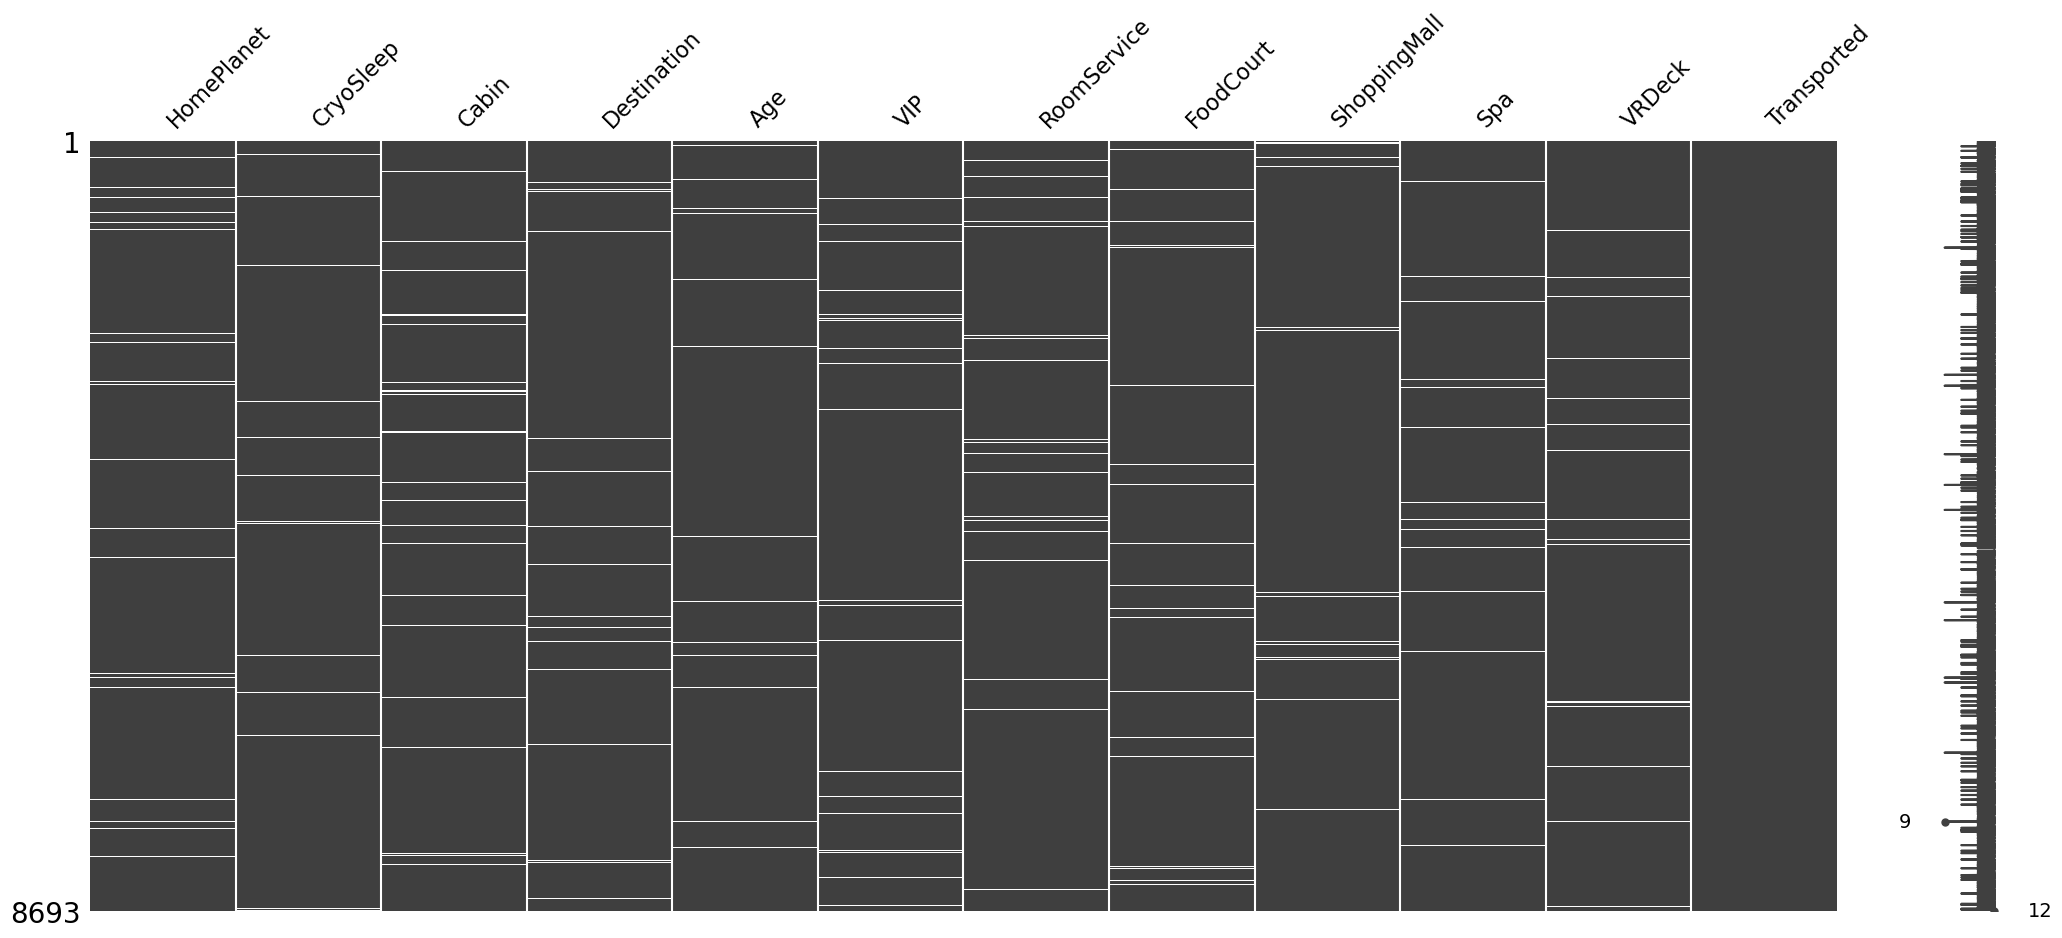

In [199]:
mno.matrix(df)
plt.show()

# Features

### Cabin

The column Cabin has as values a string in format A/000/A where the first character is the deck, the integer is the cabin's number and the last character is the side. I splitted the column in the 3 columns (Cabin_deck, Cabin_num, Cabin_side) because they are much easier to treat. First thing first though, in fact ,given that this is an important feature to predict the target and it's impossibile to assign with logic a value to the missing values, I'll drop the rows with nan on this feature

In [200]:
to_drop = df[df['Cabin'].isnull()].index
df.drop(to_drop, inplace = True)

df[['Cabin_deck', 'Cabin_num', 'Cabin_side' ]] = df.Cabin.str.split("/", expand = True)
df = df.drop(['Cabin'], axis = 1)

df['Cabin_deck'] = df['Cabin_deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1, 2, 3, 4, 5, 6, 7, 8])
df['Cabin_deck'] = df['Cabin_deck'].astype('category')

df['Cabin_num'] = df['Cabin_num'].astype('int')

df['Cabin_side'] = df['Cabin_side'].replace(['P', 'S'], [1,0])
df['Cabin_side'] = df['Cabin_side'].astype('bool')

### Luxuries (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)
Assuming that NaN in this kind of columns means that the passenger didn't spend any money in that service I replaced the NaN values with 0.

In [201]:
df['RoomService'].fillna(0.0, inplace = True)
df['FoodCourt'].fillna(0.0, inplace = True)
df['ShoppingMall'].fillna(0.0, inplace = True)
df['Spa'].fillna(0.0, inplace = True)
df['VRDeck'].fillna(0.0, inplace = True)

amount_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['Spendings'] = df[amount_columns].sum(axis = 1)
df = df.drop(amount_columns, axis = 1)

### HomePlanet

So we can see that about the half of passengers started the journey from the Earth and there are some missing values.

The number of missing values for the HomePlanet columns is 195 (2.3%)


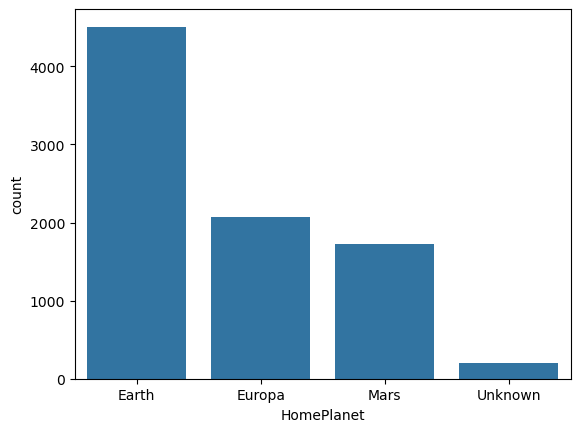

In [202]:
total_nan = df['HomePlanet'].isna().sum()
print(f'The number of missing values for the HomePlanet columns is {total_nan} ({np.round(total_nan * 100 / df.shape[0], 2)}%)')

df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
df['HomePlanet'] = df['HomePlanet'].astype('category')
sns.countplot(data = df, x = 'HomePlanet')
plt.show()

### CryoSleep

The next plot indicates that more than half passengers didn't want Cryo sleep (crazy, it's a long journey!). For the missing values the idea is pretty simple. Every passenger that haven't spent a single penny in luxuries is sleeping for the whole journey obviously. So I assumed that all the missing values in the luxuries is 0.0. If a passenger has 0.0 expenses and NaN as CryoSleep then i will replace it with True.

The number of missing values for the CryoSleep columns is 210 (2.47%)


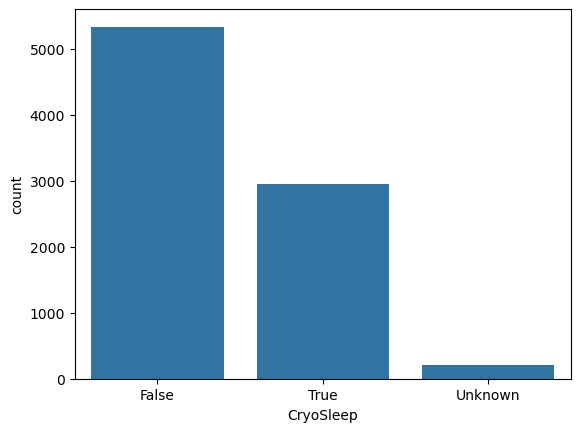

In [203]:
total_nan = df['CryoSleep'].isna().sum()
print(f'The number of missing values for the CryoSleep columns is {total_nan} ({np.round(total_nan * 100 / df.shape[0], 2)}%)')

df_viz = df.copy() 
df_viz['CryoSleep'] = df_viz['CryoSleep'].fillna('Unknown')
sns.countplot(data = df_viz, x = 'CryoSleep')
plt.show()

C:\Users\gltut\AppData\Local\Temp\ipykernel_19896\1213292969.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_nan_cryo)


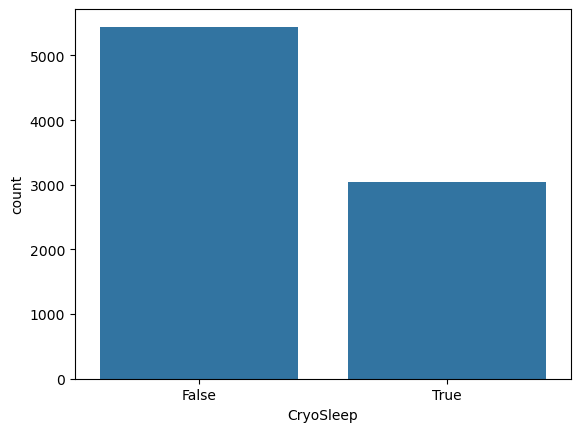

In [204]:
def is_cryo(total):
    if total == 0:
        return True
    else:
        return False

df_nan_cryo = df[df['CryoSleep'].isnull()]
df = df.drop(df_nan_cryo.index)
df_nan_cryo['CryoSleep'] = df_nan_cryo.apply(lambda row: is_cryo(row['Spendings']), axis = 1)
df = df.append(df_nan_cryo)
df = df.sort_index()

df['CryoSleep'] = df['CryoSleep'].astype('bool')

sns.countplot(data = df, x = 'CryoSleep')
plt.show()

### Destination

So the destinations are TRAPPIST-1e, PSO J318.5-22, 55 Cancri e. Here there are missing values too. But as for the HomePlanet feature i really am not sure of how much meaningful can be the destination. But for data analysis sake i did the piechart and almost the 70% of passengers' destination is TRAPPIST-1e (must be cheaper!).

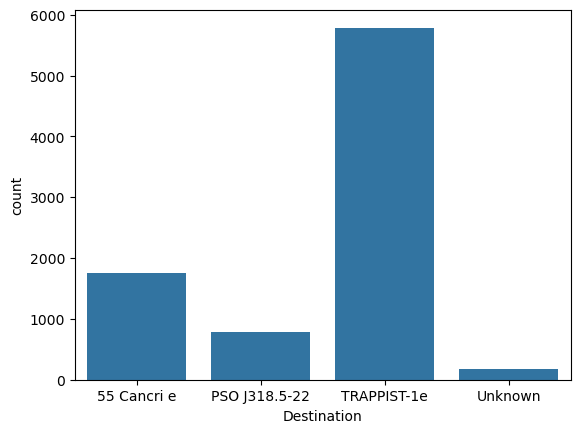

In [205]:
df['Destination'] = df['Destination'].fillna('Unknown')
df['Destination'] = df['Destination'].astype('category')
sns.countplot(data = df, x = 'Destination')
plt.show()

### Age

The histogram of the passengers' ages indicates that the majority of them is young. The distribution is quite simmetric, in fact median and mean are both really close to 28 years. But again, not sure how can passengers' age influence a natural event to hit them. For the missing values, I replaced them with the mean value.

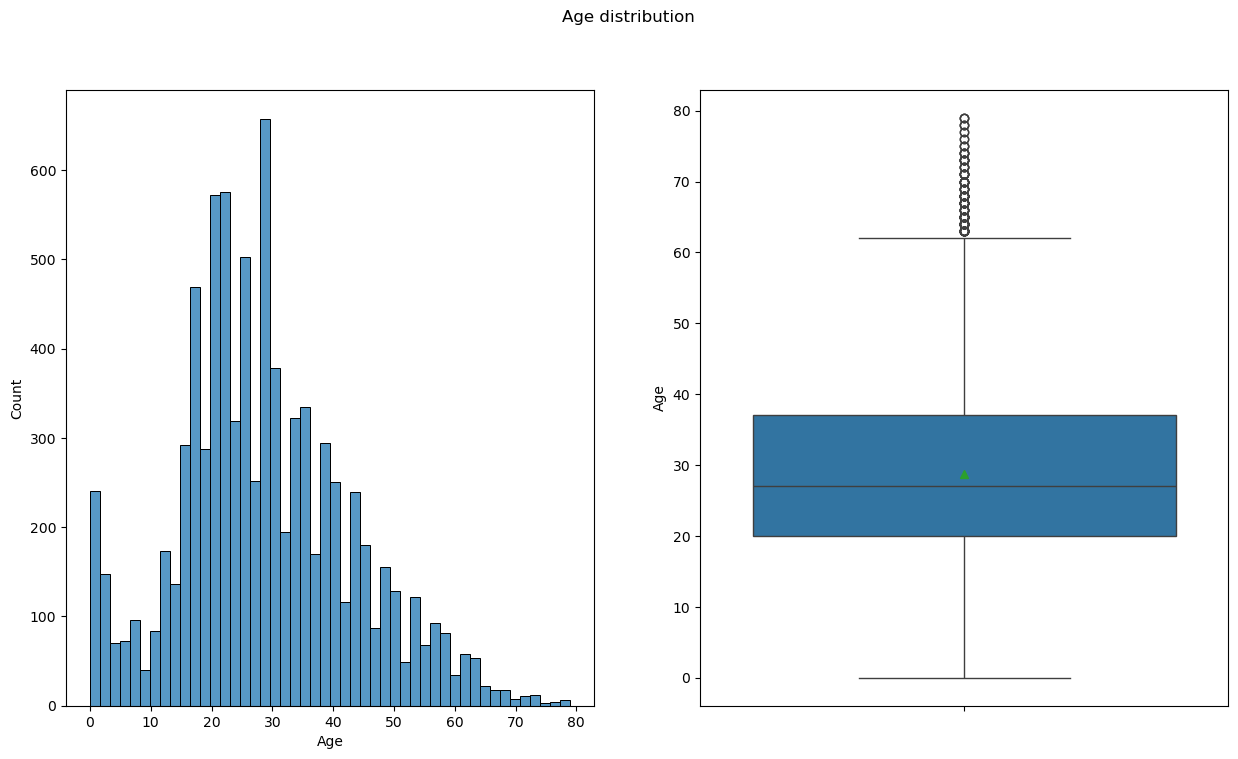

In [206]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Age'] = df['Age'].astype('int')

fig, ax = plt.subplots(1, 2, figsize = (15,8))

plt.suptitle('Age distribution')
sns.histplot(data = df, x = 'Age', ax = ax[0])
sns.boxplot(data = df, y = 'Age', ax = ax[1], showmeans = True)
plt.show()

### VIP

The following piechart shows the percentages of VIP passengers. Obviously is small (2.3%). Here, again there is about 2% of missing values. I didn't spend much time trying to predict them, in fact I dropped the rows.

HomePlanet,Earth,Europa,Mars,Unknown
VIP,,,,
False,4395,1902,1620,187
True,0,126,62,5


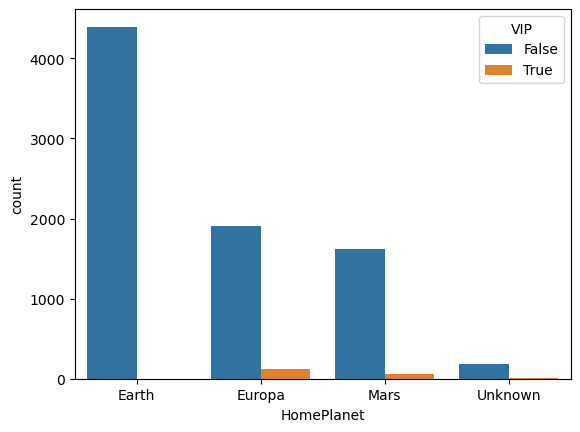

In [207]:
sns.countplot(data = df, x = 'HomePlanet', hue = 'VIP')
pd.crosstab(df['VIP'], df['HomePlanet'])

In [208]:
def is_vip(home):
    if home == 'Earth':
        return False
    else:
        return 'IDK'
    
df_nan_vip = df[df['VIP'].isnull()]
df = df.drop(df_nan_vip.index)
df_nan_vip['VIP'] = df_nan_vip.apply(lambda row: is_vip(row['HomePlanet']), axis = 1)
df = df.append(df_nan_vip)
df = df.sort_index()

df = df.drop(df[df['VIP'] == 'IDK'].index)

df['VIP'] = df['VIP'].astype('bool')

C:\Users\gltut\AppData\Local\Temp\ipykernel_19896\3301845309.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_nan_vip)


In [ ]:
df = df.reset_index(drop = 1)

# Machine learning


The idea is to first use a bunch of models only on the training dataset given from Kaggle. In this way I can use cross validation to find a model that is stable. Then i use the best models using as training dataset the whole 'train.csv' and then predict the values for 'test.csv'

Moving the target from the center of the dataset to the end for my personal pleasure

In [209]:
target = df.pop('Transported')
df.insert(df.shape[1], 'Transported', target)

The following correlation matrix shows us the correlation between variables according to pearson's coefficient. It's interesting the correlation between CryoSleep and the target.

In [210]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,CryoSleep,Age,VIP,Cabin_num,Cabin_side,Spendings,Transported
CryoSleep,1.000,-0.078,-0.080,-0.038,-0.020,-0.385,0.464
Age,-0.078,1.000,0.092,-0.129,-0.009,0.184,-0.076
VIP,-0.080,0.092,1.000,-0.099,0.010,0.161,-0.035
Cabin_num,-0.038,-0.129,-0.099,1.000,0.038,-0.213,-0.046
Cabin_side,-0.020,-0.009,0.010,0.038,1.000,-0.001,-0.106
Spendings,-0.385,0.184,0.161,-0.213,-0.001,1.000,-0.195
Transported,0.464,-0.076,-0.035,-0.046,-0.106,-0.195,1.000


But, as you know, some feature are categorical and some models don't work well with them, for example XGBoost. So I used the function get_dummies as onehot encoder.

In [211]:
df = pd.get_dummies(df, columns = ['Cabin_deck', 'HomePlanet', 'Destination'])
target = df.pop('Transported')
df.insert(df.shape[1], 'Transported', target)

At this point, i did again the correlation matrix. We can notice how there are some correlation > 0.1 with some HomePlanet value and Cabin_deck.

In [212]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,CryoSleep,Age,VIP,Cabin_num,Cabin_side,Spendings,Cabin_deck_1,Cabin_deck_2,Cabin_deck_3,Cabin_deck_4,Cabin_deck_5,Cabin_deck_6,Cabin_deck_7,Cabin_deck_8,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown,Transported
CryoSleep,1.000,-0.078,-0.080,-0.038,-0.020,-0.385,-0.031,0.124,0.034,-0.067,-0.111,-0.232,0.257,-0.018,-0.110,0.096,0.033,0.004,0.062,0.091,-0.103,-0.025,0.464
Age,-0.078,1.000,0.092,-0.129,-0.009,0.184,0.076,0.102,0.130,0.077,0.029,-0.016,-0.213,0.014,-0.196,0.214,0.016,-0.003,0.015,-0.026,-0.002,0.015,-0.076
VIP,-0.080,0.092,1.000,-0.099,0.010,0.161,0.137,0.067,0.069,0.070,-0.013,-0.058,-0.101,-0.004,-0.165,0.147,0.046,0.003,0.044,-0.002,-0.033,-0.011,-0.035
Cabin_num,-0.038,-0.129,-0.099,1.000,0.038,-0.213,-0.188,-0.271,-0.262,-0.218,-0.200,0.441,0.191,-0.029,0.367,-0.489,0.061,0.013,-0.142,0.105,0.059,-0.001,-0.046
Cabin_side,-0.020,-0.009,0.010,0.038,1.000,-0.001,-0.011,-0.027,-0.024,0.014,-0.006,0.027,0.004,0.015,0.017,-0.036,0.019,-0.003,-0.012,0.006,0.007,-0.001,-0.106
Spendings,-0.385,0.184,0.161,-0.213,-0.001,1.000,0.129,0.171,0.296,0.074,-0.016,-0.111,-0.250,0.029,-0.292,0.409,-0.067,-0.018,0.137,-0.099,-0.055,-0.008,-0.195
Cabin_deck_1,-0.031,0.076,0.137,-0.188,-0.011,0.129,1.000,-0.055,-0.054,-0.043,-0.059,-0.123,-0.116,-0.004,-0.188,0.304,-0.088,-0.008,0.093,-0.051,-0.047,-0.006,-0.005
Cabin_deck_2,0.124,0.102,0.067,-0.271,-0.027,0.171,-0.055,1.000,-0.098,-0.077,-0.107,-0.222,-0.209,-0.008,-0.340,0.549,-0.158,-0.012,0.175,-0.097,-0.093,0.002,0.147
Cabin_deck_3,0.034,0.130,0.069,-0.262,-0.024,0.296,-0.054,-0.098,1.000,-0.075,-0.104,-0.216,-0.204,-0.008,-0.331,0.533,-0.154,-0.010,0.168,-0.079,-0.093,-0.010,0.109
Cabin_deck_4,-0.067,0.077,0.070,-0.218,0.014,0.074,-0.043,-0.077,-0.075,1.000,-0.082,-0.170,-0.161,-0.006,-0.261,0.086,0.235,-0.002,0.020,-0.049,0.013,0.000,-0.033


In [265]:
target = 'Transported'
X = df.loc[:, df.columns != target]
y = df[target]

## XGBoost

Now I use the XGBoost Classifier. I use it with hyperparameter tuning and cross validation. The metric I'm using is the accuracy. At the end of the tuning I save the best model's parameters

In [266]:
max_depth_lst = list(range(3,10))
min_child_w_lst = list(range(0,3))
l_r_lst = list(range(0,3))

scores = []
models = []

# Hyperparameters' tuning
for max_depth in max_depth_lst:
    for min_child_weight in min_child_w_lst:
            for l_r in l_r_lst:
                learning_rate = l_r/10

                scores_cv = []

                for _ in range(5):
                        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=_)
                        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=_ + 5)

                        clf = xgb.XGBClassifier(n_estimators = 500, early_stopping_rounds = 50, max_depth = max_depth, 
                                                min_child_weight = min_child_weight, learning_rate = learning_rate, booster = 'gbtree')
                                
                        clf.fit(X_train, y_train,
                                eval_set = [(X_train, y_train), (X_val, y_val)],
                                verbose = False)

                        # Predicting the target for the test dataset
                        y_pred= clf.predict(X_test)

                        score = round(accuracy_score(y_test, y_pred), 3)
                        scores_cv.append(score)
                                
                
                acc = np.mean(scores_cv)

                # Print the model's parameters
                print('*********************\nParameters:')
                print(f'Max Depth: {max_depth}')
                print(f'Min Child Weight: {min_child_weight}')
                print(f'Learning rate: {learning_rate}')
                print (f"Accuracy: {round(acc, 3)}")

                param_score = (max_depth, min_child_weight, learning_rate, acc)
                models.append(param_score)



# Selection of the best model
scores = [x[-1] for x in models]
index = scores.index(max(scores))
best_clf = models[index]

print('\n*********** Best Model ***********')
print(f'Max Depth: {best_clf[0]}')
print(f'Min Child Weight: {best_clf[1]}')
print(f'Learning rate: {best_clf[2]}')
print ("Accuracy:", round(best_clf[3], 3))

	



*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.0
Accuracy: 0.498
*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.1
Accuracy: 0.756
*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.2
Accuracy: 0.754
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.0
Accuracy: 0.498
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.1
Accuracy: 0.754
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.2
Accuracy: 0.756
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.0
Accuracy: 0.498
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.1
Accuracy: 0.753
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.2
Accuracy: 0.756
*********************
Parameters:
Max Depth: 4
Min Child Weight: 0
Learning rate: 

I run again the best model to visualize the confusion matrix, accuracy and feature importance.

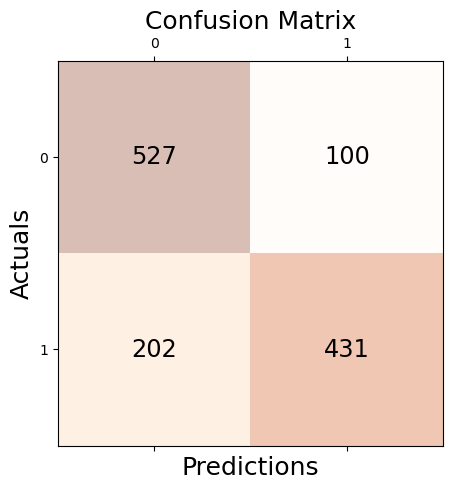

In [267]:
scores_cv = []
cm = np.array([[0,0],[0,0]])

for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=_)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=_ + 5)

        clf = xgb.XGBClassifier(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_clf[0], 
                                min_child_weight = best_clf[1], learning_rate = best_clf[2], booster = 'gbtree')
                
        clf.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_val, y_val)],
                verbose = False)

        # Predicting the target for the test dataset
        y_pred= clf.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        scores_cv.append(score)
        
        cm += confusion_matrix(y_test, y_pred)
     

acc = round(np.mean(scores_cv), 3)
cm_mean = cm//5

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm_mean, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm_mean.shape[0]):
    for j in range(cm_mean.shape[1]):
        ax.text(x=j, y=i,s=cm_mean[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
        



As we saw in the correlation matrix, the feature importance highlight the CryoSleep feature as the most important and that's interesting, but also some of the decks. It's interesting because the decks and CryoSleep referenced also to the position of the passengers. So maybe this anomaly took only a part of the ship.

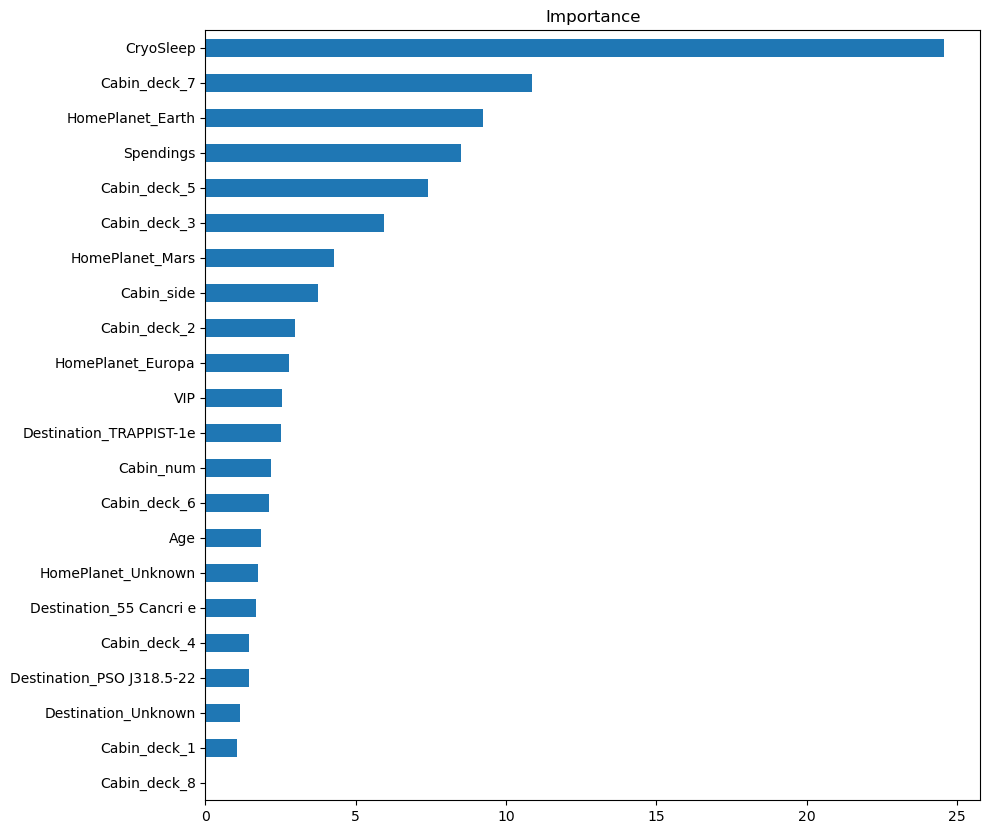

In [102]:
impor = pd.DataFrame(data = clf.feature_importances_ * 100, index = clf.feature_names_in_, columns = ['importance'])

impor.sort_values('importance').plot(kind = 'barh', title = 'Importance', legend=False, figsize = (10,10))
plt.show()

To investigate the correlation CryoSleep and Transported, I did a barplot to see how many of the non-sleeping passengers were taken and how many of the sleeping. It seems like a passenger was more likely to be taken if he was in cryo-sleep. If a passenger was not in cryosleep he had almost 33% of probability to be taken (I know that the two affirmations seem the same thing but looking at the barplot makes you understand the difference from the two situations).

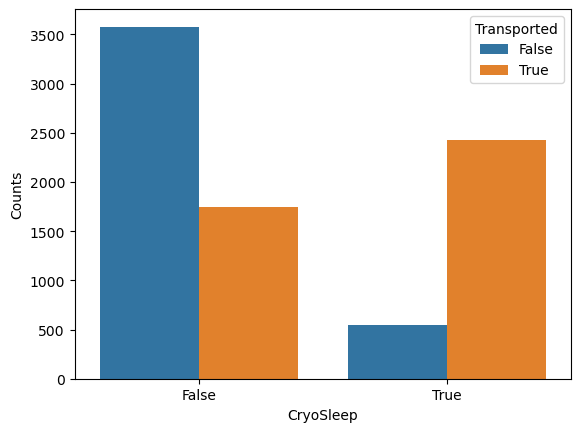

In [ ]:
a = df.groupby(['Transported', 'CryoSleep']).size().reset_index(name = 'Counts')
sns.barplot(x = 'CryoSleep', y = 'Counts', hue = 'Transported', data = a)
plt.show()

In [270]:
# save to JSON
clf.save_model("models/xgb_model.json")

# MLP

## Pre-processing

In [227]:
df2 = df.copy()

# Scaling the numerical variables
numerical = ['Spendings', 'Cabin_num']
df_num = df2[numerical].copy()
scaler = StandardScaler()  
df_num1 = scaler.fit_transform(df_num)
df_num1 = pd.DataFrame(df_num1, columns = df_num.columns.values)

# Merging the categorical and numerical variables
df2['Spendings'] = df_num1['Spendings']
df2['Cabin_num'] = df_num1['Cabin_num']
df2

,CryoSleep,Age,VIP,Cabin_num,Cabin_side,Spendings,Cabin_deck_1,Cabin_deck_2,Cabin_deck_3,Cabin_deck_4,...,Cabin_deck_8,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown,Transported
0,False,39,False,-1.175787,True,-0.514857,0,1,0,0,...,0,0,1,0,0,0,0,1,0,False
1,False,24,False,-1.175787,False,-0.249563,0,0,0,0,...,0,1,0,0,0,0,0,1,0,True
2,False,58,True,-1.175787,False,3.227729,1,0,0,0,...,0,0,1,0,0,0,0,1,0,False
3,False,33,False,-1.175787,False,1.350849,1,0,0,0,...,0,0,1,0,0,0,0,1,0,False
4,False,16,False,-1.173834,False,-0.121602,0,0,0,0,...,0,1,0,0,0,0,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8404,False,41,True,-0.984364,True,2.561972,1,0,0,0,...,0,0,1,0,0,1,0,0,0,False
8405,True,18,False,1.752214,False,-0.514857,0,0,0,0,...,0,1,0,0,0,0,1,0,0,False
8406,False,26,False,1.754168,False,0.160272,0,0,0,0,...,0,1,0,0,0,0,0,1,0,True
8407,False,32,False,0.011821,False,1.156565,0,0,0,0,...,0,0,1,0,0,1,0,0,0,False


In [236]:
bool_cols = ['CryoSleep', 'VIP', 'Cabin_side', 'Transported']
for col in bool_cols:
    df2[col] = df2[col].astype('int')

In [237]:
target = 'Transported'
X = df2.loc[:, df2.columns != target]
y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=2)

In [256]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Best parameters
neurons, activation, batch_size, opt = 16, 'relu', 8, 'Adam'

# Creation of the model
model = Sequential()
model.add(Dense(neurons, input_dim = X_train.shape[1], activation = activation))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

# Condition of early stopping by monitoring the recall on the validation set
es = EarlyStopping(monitor='val_accuracy', 
                mode='max',
                patience=15,
                restore_best_weights=True)

# Fitting the model and storing all metrics in the variable history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose = 1, epochs = 50, batch_size = batch_size, callbacks=[es])

Epoch 1/50
736/736 [==============================] - 1s 1ms/step - loss: 0.7663 - accuracy: 0.6570 - precision: 0.6707 - recall: 0.6223 - val_loss: 0.5413 - val_accuracy: 0.7462 - val_precision: 0.8281 - val_recall: 0.6240
Epoch 2/50
736/736 [==============================] - 1s 1ms/step - loss: 0.5397 - accuracy: 0.7302 - precision: 0.7722 - recall: 0.6562 - val_loss: 0.5284 - val_accuracy: 0.7375 - val_precision: 0.7766 - val_recall: 0.6698
Epoch 3/50
736/736 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7311 - precision: 0.7753 - recall: 0.6538 - val_loss: 0.5376 - val_accuracy: 0.7129 - val_precision: 0.7218 - val_recall: 0.6967
Epoch 4/50
736/736 [==============================] - 1s 1ms/step - loss: 0.5277 - accuracy: 0.7358 - precision: 0.7836 - recall: 0.6545 - val_loss: 0.5247 - val_accuracy: 0.7470 - val_precision: 0.8326 - val_recall: 0.6209
Epoch 5/50
736/736 [==============================] - 1s 1ms/step - loss: 0.5261 - accuracy: 0.7362 - pr

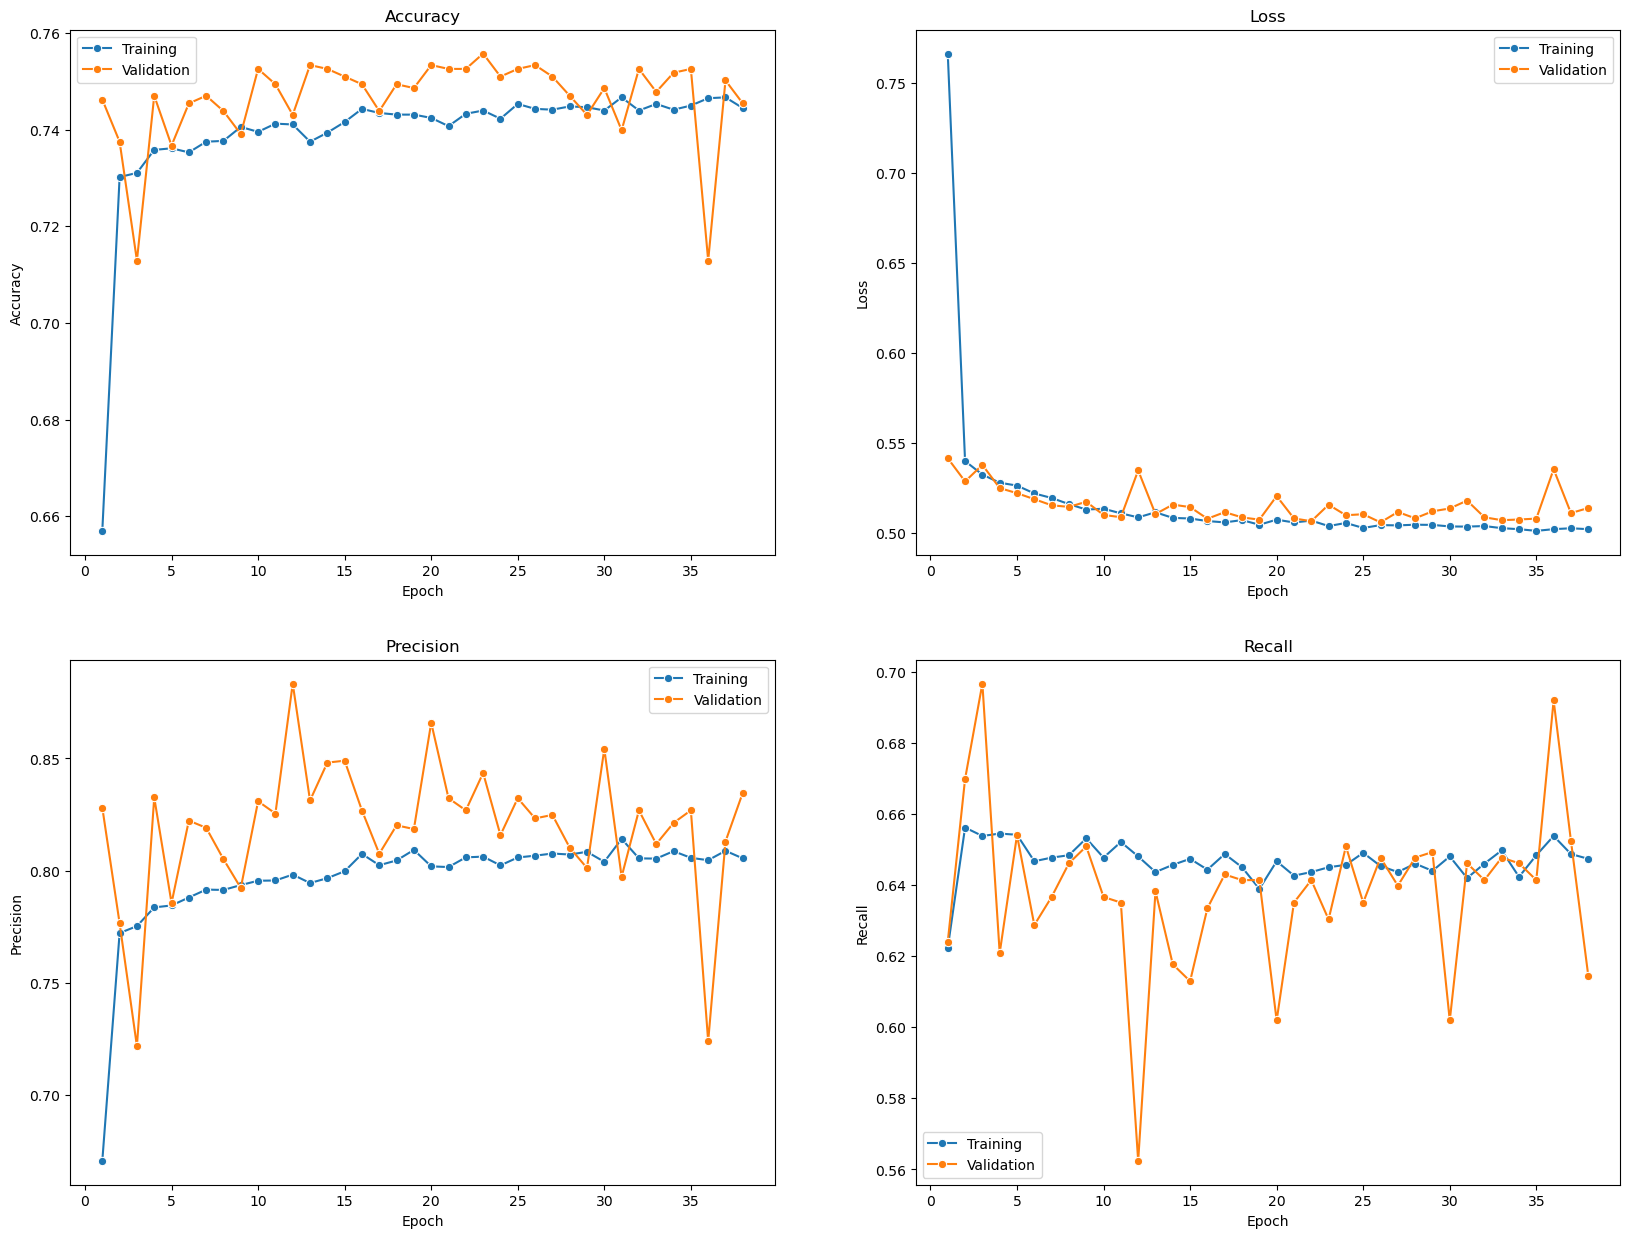

In [258]:
# METRICS PLOTTING
history_df  = pd.DataFrame(history.history)
x = range(1, history_df.shape[0]+1)

fig, axes = plt.subplots(2, 2, figsize = (20,15))

# Accuracy plots
sns.lineplot(data = history_df, x = x, y = 'accuracy', marker = 'o', label = 'Training', ax = axes[0, 0])
sns.lineplot(data = history_df, x = x, y = 'val_accuracy', marker = 'o', label = 'Validation', ax = axes[0, 0])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss plots
sns.lineplot(data = history_df, x = x, y = 'loss', marker = 'o', label = 'Training', ax = axes[0, 1])
sns.lineplot(data = history_df, x = x, y = 'val_loss', marker = 'o', label = 'Validation', ax = axes[0, 1])
axes[0, 1].set_title('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision plots
sns.lineplot(data = history_df, x = x, y = 'precision', marker = 'o', label = 'Training', ax = axes[1, 0])
sns.lineplot(data = history_df, x = x, y = 'val_precision', marker = 'o', label = 'Validation', ax = axes[1, 0])
axes[1, 0].set_title('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall plots
sns.lineplot(data = history_df, x = x, y = 'recall', marker = 'o', label = 'Training', ax = axes[1, 1])
sns.lineplot(data = history_df, x = x, y = 'val_recall', marker = 'o', label = 'Validation', ax = axes[1, 1])
axes[1, 1].set_title('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()


plt.show()

40/40 [==============================] - 0s 850us/step
              precision    recall  f1-score   support

           0       0.71      0.86      0.77       628
           1       0.82      0.65      0.72       634

    accuracy                           0.75      1262
   macro avg       0.76      0.75      0.75      1262
weighted avg       0.76      0.75      0.75      1262



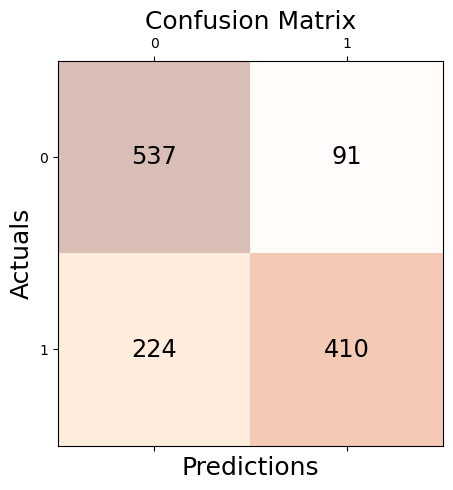

In [261]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(X_test)
y_pred_binary = np.round(predictions, 0)

# Plotting confusion matrix
result = confusion_matrix(y_test, y_pred_binary)
print(classification_report(y_test, y_pred_binary))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(result, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=result[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [268]:
model.save('models/mlp_model.keras')